In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mldec.datasets import toy_problem_data
from mldec.models import baselines
from mldec.utils import evaluation
from mldec.codes import repetition_code

### Analysis notes

 - Feb 26 runs: 50k training data, p=0.15, knob turning = [0.1, 0.15, 0.2, 0.25]
   - Basically the run failed: No discernable difference between any of the p performances. Hypothesis is that this is due to a very large training sample: basically all of our runs get to "see" the important examples for 50000 data points. So lets choke that and see what happens. Trying again for 1k 

- Feb 27 runs: 1k training data, p=0.15, knob turning = [0.1, 0.15, 0.2, 0.25]
  - still no signal. Lets try to really boost what we're looking for. I will make true p smaller, bias smaller, and a knob p much larger so if there is any training difference we should se it. $p=0.1$, $\alpha=0.7$ and knob goes either $p\in [0.1, 0.3]$. $N=2000$ and doubled the patience to 4000 epochs.

- Feb 28 runs: Found a bug. 2k training data, p=0.10, alpha=0.7
- April 23 runs: Threw in FFNN experiments because they take 20 minutes...

In [2]:
# target = "cnn_toy_problem_results_N1000.csv"


# model = "transformer"
target_xformer = "xformer-v0/transformer_toy_problem_results_N2000.csv"
target_cnn = "cnn-v0/cnn_toy_problem_results_N2000_v4.csv"
target_ffnn = "ffnn-v1.0/ffnn_toy_problem_results_N2000.csv"

# model = "cnn"
# target = "cnn_toy_problem_results_N2000_v4.csv"

# model = "cnn"
# target = "cnn_toy_problem_results_N100.csv"

df_x = pd.read_csv(target_xformer)
df_cnn = pd.read_csv(target_cnn)
df_ffnn = pd.read_csv(target_ffnn)


In [3]:
# compute optimal performance on this dataset

p = 0.1
alpha = 0.7
n = 8
dataset_config = {"p": p, "alpha": alpha, "pcm": toy_problem_data.repetition_pcm(n)}
X, Y, good_weights = toy_problem_data.uniform_over_good_examples(n, dataset_config)
X, Y, true_weights = toy_problem_data.create_dataset_training(n, dataset_config)

# sort_idx = reversed(np.argsort(true_weights))
# plt.plot(range(2 ** n), good_weights[sort_idx], alpha=0.5)
# plt.plot(range(2 ** n), true_weights[sort_idx], alpha=0.5)
# plt.semilogy()

mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights)
mld_acc = evaluation.weighted_accuracy(mld, X, Y, true_weights) 
print(f"Lookup table accuracy: {mld_acc}")

Lookup table accuracy: 0.9988024234771729


C:\Users\peter\Desktop\projects\mldec\src\mldec\models\baselines.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(out)


In [4]:
# solve for the violation of wellorderedness 
def froot(x):
    return (x / (1-x)) ** 4 - ( (alpha * x) / (1 - alpha * x)) ** 2

# find the root
from scipy.optimize import root_scalar
root = root_scalar(froot, x0=0.5) #overshoot since 0 is also a root
print(root)

      converged: True
           flag: converged
 function_calls: 14
     iterations: 7
           root: 0.37269071549105337
         method: newton


In [5]:
n_samp = 22
alpha_samp = 0.33
p1_samp = 0.15
p2_samp = p1_samp * alpha
good_wt_hist, unimp_wt_hist, imp_wt_hist, bad_wt_hist, all_wt_hist = repetition_code.histogram_good_important_bad(n_samp, p1_samp, alpha_samp)
# turning the knob
pp_samp = 0.25
good_wt_hist_k, unimp_wt_hist_k, imp_wt_hist_k, bad_wt_hist_k, all_wt_hist_k = repetition_code.histogram_good_important_bad(n_samp, pp_samp, alpha_samp)
weights = np.array(list(imp_wt_hist.keys()))

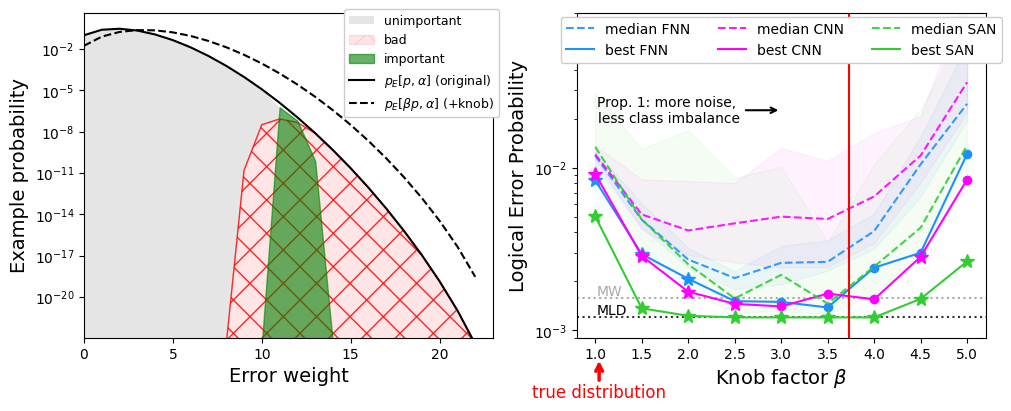

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# FIG 1A: DISTRIBUTION OF EXAMPLES FOR GOOD/BAD/IMPORTANT
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def dezero(x, y, zero=0):
    y = np.array(list(y))
    y[y == 0] = zero
    x[y == 0] = zero
    return x, y
    # return x[y >= zero], y[y >= zero]

x_all, y_all = dezero(weights, all_wt_hist.values())
zero = min(y_all)
x_good, y_good = dezero(weights, good_wt_hist.values(), zero=zero)
x_unimp, y_unimp = dezero(weights, unimp_wt_hist.values(), zero=zero)
x_imp, y_imp = dezero(weights, imp_wt_hist.values(), zero=zero)
x_bad, y_bad = dezero(weights, bad_wt_hist.values(), zero=zero)

w = 1/3
ax0 = axes[0]
zero = min(y_all)
ax0.fill_between(x_unimp[:n_samp//2 + 1], y_bad[:n_samp//2 + 1], y_unimp[:n_samp//2 + 1], 
                 label='unimportant', facecolor="gray", alpha=0.2)
ax0.fill_between(x_bad, np.ones_like(y_bad) * zero, y_bad, 
                 label='bad', facecolor="r", hatch="x", edgecolor="r", alpha=0.1)
ax0.fill_between(x_bad, np.ones_like(y_bad) * zero, y_bad, 
                 facecolor='none', hatch="x", edgecolor="r", alpha=0.8) #matplotlib rendering bug https://stackoverflow.com/questions/5195466/matplotlib-does-not-display-hatching-when-rendering-to-pdf
ax0.fill_between(x_imp, np.ones_like(y_imp) * zero, y_imp, label='important', facecolor="g", edgecolor='g', alpha=0.6, )
ymin = zero * 3


# overlay of turning the knob
x_all_pp, y_all_pp = dezero(weights, all_wt_hist_k.values())
ax0.plot(x_all, y_all, label=r'$p_E[p, \alpha]$ (original)', color='k', alpha=1)
ax0.plot(x_all_pp, y_all_pp, label=r"$p_E[\beta p, \alpha]$ (+knob)", color='k', alpha=1, linestyle='--')
ax0.semilogy()
labelsz = 14
ax0.set_xlabel(r"Error weight", fontsize=labelsz)
ax0.set_ylabel('Example probability', fontsize=labelsz)
ax0.legend(prop={'size': 9}, framealpha=1, loc='upper right', bbox_to_anchor=(1.03, 1.03))

ax0.set_ylim(ymin, ax0.get_ylim()[1] + 0.1)
ax0.set_xlim(0, n_samp + 1)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# FIG 1B: PERFORMANCE WITH TURNING THE KNOB
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
#get the min weight performance
colors = ['dodgerblue', 'fuchsia', 'limegreen']
ax = axes[1]
vs_minweight = df_x[df_x['p'] == p]['vs_minweight'].values
minweight = df_x[df_x['p'] == p]['val_acc'] - vs_minweight
min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...
ax.axhline(min_minweight_err, ls=':', c='darkgray', alpha=1)#, label='minimum weight')
ax.axhline(1 - mld_acc , ls=':', c='k', alpha=0.8)#, label='MLD')
ax.text(1.02, min_minweight_err + 0.00005, f"MW", c='darkgray', size=10, ha='left')
ax.text(1.02, 1 - mld_acc + 0.00005 , f"MLD", size=10, ha='left')

for jj, (df, model) in enumerate(zip([df_ffnn, df_cnn, df_x], ['FNN', 'CNN', 'SAN'])):
 
    # compute performance/stats on each of the models
    pvals = sorted(df['p'].unique())
    xvals = np.array(pvals) / 0.1
    yerrs_meds = []
    yerrs_mins = []
    yerrs_ub = []
    yerrs_lb = []
    better_than_lookup_arr = [] # track when the model is better than the lookup table
    for i, p in enumerate(pvals):
        y = df[df['p'] == p]['val_acc']
        y_err = 1 - y
        yerrs_meds.append(y_err.median())
        # get 
        y_ub = y_err.quantile(.75)
        y_lb = y_err.quantile(0.25)
        yerrs_ub.append(y_ub)
        yerrs_lb.append(y_lb)
        yerrs_mins.append(y_err.min())

        # # Also get the min weight performance
        # vs_minweight = df[df['p'] == p]['vs_minweight'].values
        # minweight = y - vs_minweight
        # min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...

        # now, find the comparison of this plot to the lookup table on the plot
        vs_lookup = df[df['p'] == p]['vs_lookup'][y.idxmax()]
        better_than_lookup = vs_lookup > 0
        better_than_lookup_arr.append(better_than_lookup)
    
    yerrs_meds = np.array(yerrs_meds)
    yerrs_mins = np.array(yerrs_mins)
    yerrs_ub = np.array(yerrs_ub)
    yerrs_lb = np.array(yerrs_lb)
    color = colors[jj]
    ax.fill_between(xvals, yerrs_lb, yerrs_ub, color=color, alpha=0.05)
    ax.plot(xvals, yerrs_meds, ls='--', marker=None, c=color, alpha=0.9, label=f'median {model}')
    ax.plot(xvals, yerrs_mins, ls='-', marker=None, c=color, label=f'best {model}')
    # wherever the result is better than lookup, plot a star
    for i, p in enumerate(pvals):
        if better_than_lookup_arr[i]:
            marker = '*'
            markersize = 10
        else:
            marker = 'o'
            markersize = 6
        ax.plot(p / 0.1, yerrs_mins[i], marker=marker, c=color, markersize=markersize)



ax.set_xlabel(r"Knob factor $\beta$", size=14)
# draw an arrow pointing to x=0.10, y=0.01
ax.semilogy()
ax.axvline(root.root / 0.1, ls='-', c='red', alpha=1)
ax.legend(framealpha=1, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.01))
ax.set_ylim([9e-4, 9e-2])
ax.set_ylabel("Logical Error Probability", size=14)
    
# Add an arrow annotation below the x-axis pointing at x=1
axes[1].annotate("true distribution", 
            xy=(0.055, -0.05 ),  # Use axis coordinates (x, y)
            xytext=(0.055, -0.14),  # Position text below the axis using axis coordinates
            size=12,  
            ha='center',
            va='top',
            color='red',
            # fontweight='bold',  # Make text bold to increase visibility
            # bbox=dict(facecolor='white', alpha=0.7, edgecolor='red', pad=3),  # Add background to text
            arrowprops=dict(
                arrowstyle='->',
                color='red',
                linewidth=2.5,  # Increased linewidth for visibility
                shrinkA=0,
                shrinkB=5  # Added some shrinkage to avoid overlapping with text
            ),
            xycoords='axes fraction',  # Use data coordinates for the arrow endpoint
            textcoords='axes fraction')  # Use axis fraction coordinates for the text
axes[1].annotate("Prop. 1: more noise, \nless class imbalance", 
            xy=(0.5, .7 ),  # Use axis coordinates (x, y)
            xytext=(0.4, .7 ),  # Position text further left to avoid overlap
            size=10,  
            ha='right',
            va='center',
            color='k',
            # bbox=dict(facecolor='white', alpha=0.7, edgecolor='k', pad=3),  # Add background to text
            arrowprops=dict(
                arrowstyle='->',
                color='k',
                linewidth=1.5,  # Increased linewidth for visibility
                # shrinkA=200,  # Ensure arrow starts outside the text box
                # shrinkB=200  # Added some shrinkage to avoid overlapping with text
            ),
            xycoords='axes fraction',  # Use data coordinates for the arrow endpoint
            textcoords='axes fraction')  # Use axis fraction coordinates for the text

axes[1].annotate("", xy=(0.10, yerrs_mins[0] * .9), xytext=(0.10, yerrs_mins[0] *.35 ), arrowprops=dict(arrowstyle='->', color='r', linewidth=2))


fig.savefig(f"../../figures/fig1_full.pdf", bbox_inches='tight')

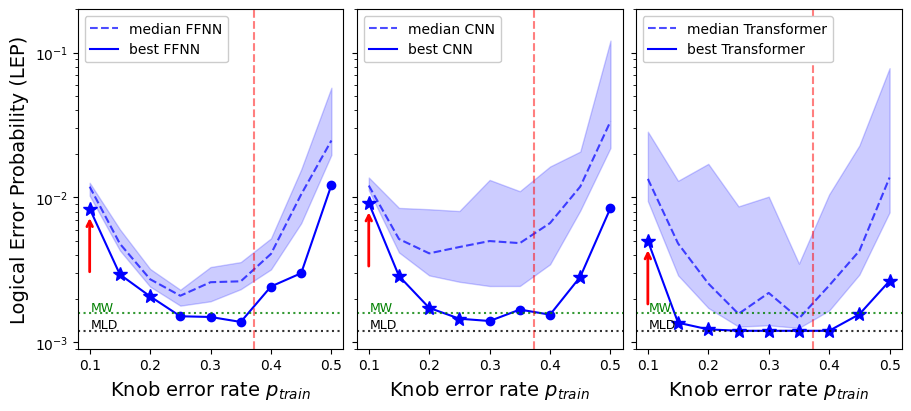

In [21]:
# fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharey=True, constrained_layout=True)

# for jj, (df, model) in enumerate(zip([df_ffnn, df_cnn, df_x], ['FFNN', 'CNN', 'Transformer'])):
 
#     ax = axes[jj]
#     # compute performance/stats on each of the models
#     pvals = sorted(df['p'].unique())
#     yerrs_meds = []
#     yerrs_mins = []
#     yerrs_ub = []
#     yerrs_lb = []
#     better_than_lookup_arr = [] # track when the model is better than the lookup table
#     for i, p in enumerate(pvals):
#         y = df[df['p'] == p]['val_acc']
#         y_err = 1 - y
#         yerrs_meds.append(y_err.median())
#         # get 
#         y_ub = y_err.quantile(.75)
#         y_lb = y_err.quantile(0.25)
#         yerrs_ub.append(y_ub)
#         yerrs_lb.append(y_lb)
#         yerrs_mins.append(y_err.min())

#         # Also get the min weight performance
#         vs_minweight = df[df['p'] == p]['vs_minweight'].values
#         minweight = y - vs_minweight
#         min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...

#         # now, find the comparison of this plot to the lookup table on the plot
#         vs_lookup = df[df['p'] == p]['vs_lookup'][y.idxmax()]
#         better_than_lookup = vs_lookup > 0
#         better_than_lookup_arr.append(better_than_lookup)
    
#     yerrs_meds = np.array(yerrs_meds)
#     yerrs_mins = np.array(yerrs_mins)
#     yerrs_ub = np.array(yerrs_ub)
#     yerrs_lb = np.array(yerrs_lb)
#     ax.fill_between(pvals, yerrs_lb, yerrs_ub, color='b', alpha=0.2)
#     ax.plot(pvals, yerrs_meds, ls='--', marker=None, c='b', alpha=0.7, label=f'median {model}')
#     ax.plot(pvals, yerrs_mins, ls='-', marker=None, c='b', label=f'best {model}')
#     # wherever the result is better than lookup, plot a star
#     for i, p in enumerate(pvals):
#         if better_than_lookup_arr[i]:
#             marker = '*'
#             markersize = 10
#         else:
#             marker = 'o'
#             markersize = 6
#         ax.plot(p, yerrs_mins[i], marker=marker, c='b', markersize=markersize)

#     ax.set_xlabel(r"Knob error rate $p_{train}$", size=14)
#     ax.axhline(min_minweight_err, ls=':', c='g', alpha=0.8)#, label='minimum weight')
#     ax.axhline(1 - mld_acc , ls=':', c='k', alpha=0.8)#, label='MLD')

#     ax.text(0.102, min_minweight_err + 0.00005, f"MW", c='g', size=9, ha='left')
#     ax.text(0.102, 1 - mld_acc + 0.00005 , f"MLD", size=9, ha='left')
#     # draw an arrow pointing to x=0.10, y=0.01
#     ax.annotate("", xy=(0.10, yerrs_mins[0] * .9), xytext=(0.10, yerrs_mins[0] *.35 ), arrowprops=dict(arrowstyle='->', color='r', linewidth=2))
#     ax.semilogy()
#     ax.axvline(root.root, ls='--', c='r', alpha=0.5)
#     ax.legend(framealpha=1, loc='upper left')


# axes[0].set_ylim([9e-4, 2e-1])
# axes[0].set_ylabel("Logical Error Probability (LEP)", size=14)
    
# fig.savefig(f"../../figures/agg_toy_problem.pdf", bbox_inches='tight')

In [114]:
from math import comb
p = 0.085
n = 8
x = comb(n, n//2) * (1-p)**(n//2) * p**(n//2)
print(1 / x)

390.4288314039677


A comment/graph for the appendix:
 - in general, the lookup table performs better, but this is possibly confounded by $N >> 2^n$. And, in this toy problem, when the model is given knob-turned data then a perfectly valid strategy is to attempt memorization, which becomes an increasingly good strategy as $N$ continues to grow. On the other hand, if we were to restrict $N$ to be smaller than $2^n$ our problem there are equally valid concerns: The models are then _extremely_ overparameterized

0.0028799176216125
0.0011952519416809
0.0009235739707946
6.628036499023438e-05
-0.0001193284988403
-0.0001949071884155
-9.191036224365234e-05
9.906291961669922e-05
-0.0007628202438354


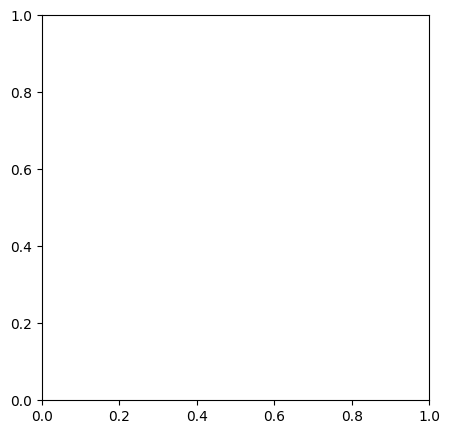

In [95]:
fig, ax = plt.subplots(figsize=(5, 5))
pvals = sorted(df['p'].unique())
yerrs_meds = []
yerrs_mins = []
yerrs_ub = []
yerrs_lb = []
for i, p in enumerate(pvals):

    vs_lookup = df[df['p'] == p]['vs_lookup']
    y = df[df['p'] == p]['val_acc']
    x = y - vs_lookup

    # find the row with best val_acc, and get the value for 'vs_lookup'
    best_val_acc = y.max()
    best_vs_lookup = vs_lookup[y.idxmax()]
    print(best_vs_lookup)

# yerrs_meds = np.array(yerrs_meds)
# yerrs_mins = np.array(yerrs_mins)
# yerrs_ub = np.array(yerrs_ub)
# yerrs_lb = np.array(yerrs_lb)
# ax.fill_between(pvals, yerrs_lb, yerrs_ub, color='b', alpha=0.2)
# ax.plot(pvals, yerrs_meds, ls='--', marker='o', c='b', alpha=0.7, label='median CNN')
# ax.plot(pvals, yerrs_mins, ls='-', marker='o', c='b', label='best CNN')
# ax.set_xlabel(r"Simulated error rate $p$", size=14)
# ax.set_ylabel("Logical Error Probability", size=14)
# # ax.set_ylim([9e-4, 2e-1])
# ax.axhline(min_minweight_err, ls=':', c='r', alpha=0.8, label='minimum weight')
# ax.axhline(1 - mld_acc, ls=':', c='k', alpha=0.8, label='MLD')

# ax.semilogy()
# ax.legend()
    
# fig.savefig("../../figures/cnn_toy_problem.pdf", bbox_inches='tight')

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
p= 0.1 mean= 0.01842501521110534 median= 0.012088924646377619
p= 0.15 mean= 0.010748124718666058 median= 0.005160123109817394
p= 0.2 mean= 0.012555318772792817 median= 0.004108250141143799
p= 0.25 mean= 0.014664412140846256 median= 0.004544317722320501
p= 0.3 mean= 0.026483100056648258 median= 0.00499764084815979
p= 0.35 mean= 0.023337972164154053 median= 0.0048346817493438166
p= 0.4 mean= 0.0435709747672081 median= 0.006653875112533625
p= 0.45 mean= 0.06375062882900238 median= 0.01189449429512024
p= 0.5 mean= 0.1318560031056404 median= 0.03362986445426941


Text(0.5, 0, 'error')

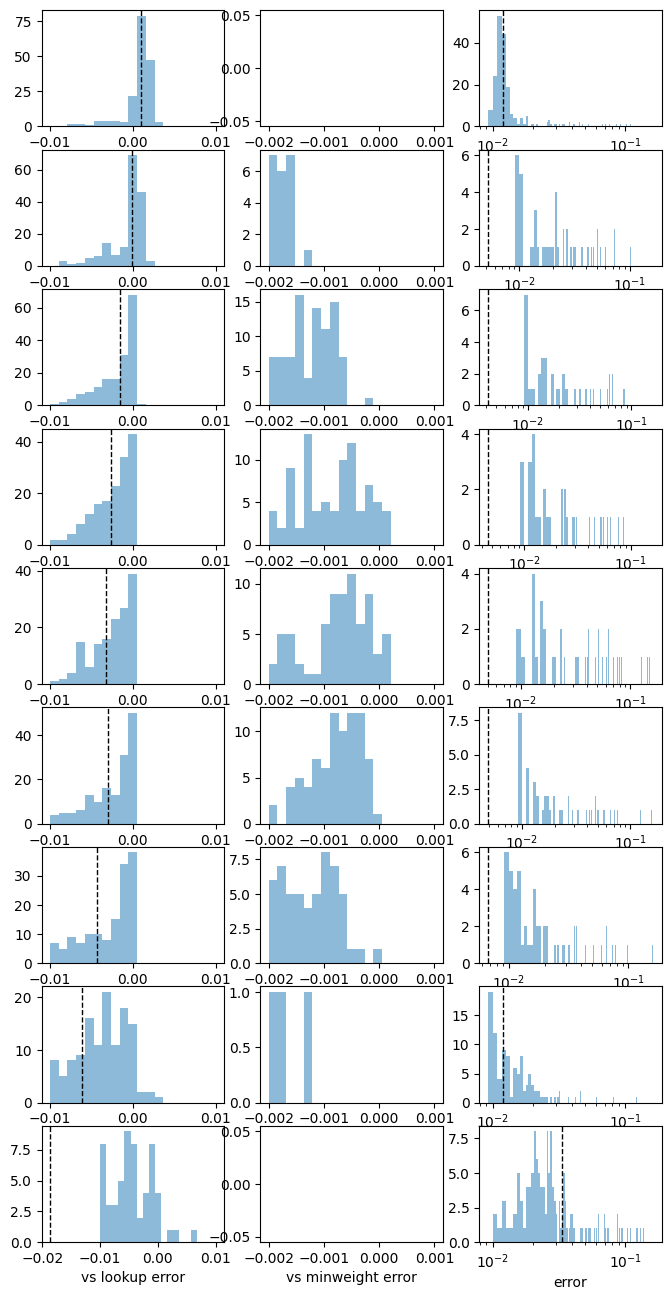

In [63]:


pvals = sorted(df['p'].unique())

fig, axes = plt.subplots(len(pvals), 3, figsize=(8, 16))
# axes = [axes]

print(pvals)
# bins1 = 'auto'
# bins2 = 'auto'
bins3 = 'auto'
bins1 = np.linspace(-0.01, 0.01, 20) # overwrite
bins2 = np.linspace(-0.002, 0.001, 20)
# bins3 = np.linspace(1e-5, 3e-3, 20)
for i, p in enumerate(pvals):
    y = df[df['p'] == p]['val_acc'].values
    vs_lookup = df[df['p'] == p]['vs_lookup'].values
    lookup = y - vs_lookup
    lookup_err = 1 - lookup
    cts, bins1, patches = axes[i, 0].hist(vs_lookup, label=f'p={p}', bins=bins1, alpha=0.5)
    axes[i, 0].axvline(np.median(vs_lookup), color='k', linestyle='dashed', linewidth=1)

    # print(vs_lookup)

    vs_minweight = df[df['p'] == p]['vs_minweight'].values
    minweight = y - vs_minweight
    minweight_err = 1 - minweight
    minweight_err = np.round(minweight_err, 7) # machine precision errors from the subtraction op above...
    cts, bins2, patches = axes[i, 1].hist(vs_minweight, label=f'p={p}', bins=bins2, alpha=0.5)
    # print(vs_minweight)

    y_err = 1 - y
    vs_lookup = vs_lookup[vs_lookup > -0.005]
    cts, bins3, patches = axes[i, 2].hist(y_err, label=f'p={p}', bins=bins3, alpha=0.5)
    # vline at the mean
    mean = np.mean(y_err)
    median = np.median(y_err)
    print("p=", p, "mean=", mean, "median=", median)
    axes[i, 2].axvline(median, color='k', linestyle='dashed', linewidth=1)
    axes[i, 2].semilogx()



# # set xlim and ylim equal
# lb = 1.1e-3
# ub = 1.5e-3
# axes[0].set_xlim([lb, ub])
# axes[0].set_ylim([lb, ub])

# log scale for both axes
# for ax in axes:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.legend()

axes[-1, 0].set_xlabel('vs lookup error')
axes[-1, 1].set_xlabel('vs minweight error')
axes[-1, 2].set_xlabel('error')
# axes[0].set_ylabel('ml error')




Lookup table accuracy: 0.9988024234771729


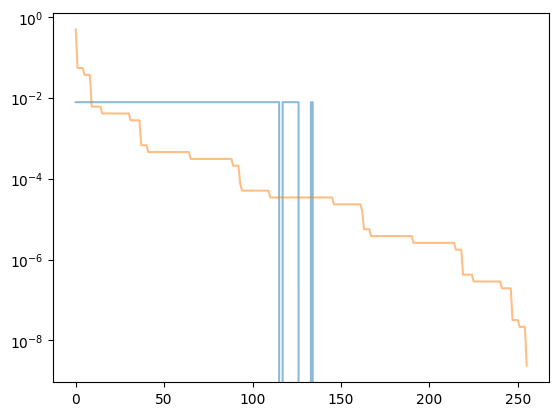

In [3]:
from mldec.datasets import toy_problem_data
from mldec.models import baselines
from mldec.utils import evaluation
p = 0.1
alpha = 0.7
n = 8
dataset_config = {"p": p, "alpha": alpha, "pcm": toy_problem_data.repetition_pcm(n)}
X, Y, good_weights = toy_problem_data.uniform_over_good_examples(n, dataset_config)
X, Y, true_weights = toy_problem_data.create_dataset_training(n, dataset_config)

sort_idx = reversed(np.argsort(true_weights))
plt.plot(range(2 ** n), good_weights[sort_idx], alpha=0.5)
plt.plot(range(2 ** n), true_weights[sort_idx], alpha=0.5)
plt.semilogy()

mld = baselines.RepetitionCodeLookupTable()
mld.train_on_histogram(X, Y, good_weights)
mld_acc = evaluation.weighted_accuracy(mld, X, Y, true_weights) 
print(f"Lookup table accuracy: {mld_acc}")

In [ ]:
target = "transformer_toy_problem_results_N1000.csv"
df = pd.read_csv(target)

Text(0, 0.5, 'ml error')

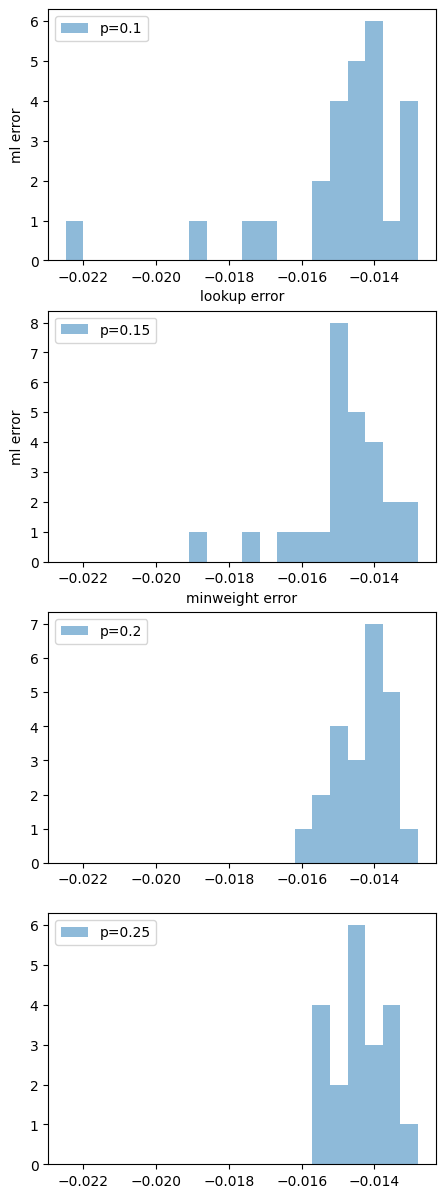

In [86]:
import numpy as np
fig, axes = plt.subplots(4, 1, figsize=(5, 15))

pvals = sorted(df['p'].unique())
bins = 20 # overwrite
for i, p in enumerate(pvals):
    y = df[df['p'] == p]['val_acc'].values
    vs_lookup = df[df['p'] == p]['vs_lookup'].values
    lookup = y - vs_lookup
    lookup_err = 1 - lookup
    y_err = 1 - y

    vs_minweight = df[df['p'] == p]['vs_minweight'].values
    minweight = y - vs_minweight
    minweight_err = 1 - minweight
    minweight_err = np.round(minweight_err, 7) # machine precision errors from the subtraction op above...

    # outlier removal on vs_minweight: remove the top and bottom 1% of the data
    # vs_minweight = vs_minweight[vs_minweight >  0.00 ]
    cts, bins, patches = axes[i].hist(vs_minweight, bins=bins, alpha=0.5, label=f'p={p}')

    # axes[0].scatter([p] * len(vs_lookup), vs_lookup, label=f'p={p}', alpha=0.5)
    # axes[1].scatter([p] * len(vs_minweight), vs_minweight, label=f'p={p}', alpha=0.5)


# log scale for both axes
for ax in axes:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    ax.legend()

axes[0].set_xlabel('lookup error')
axes[0].set_ylabel('ml error')

axes[1].set_xlabel('minweight error')
axes[1].set_ylabel('ml error')


In [ ]:
lblb1

In [25]:
minweight_err

array([0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652, 0.0028652,
       0.0028652, 0.0028652, 0.0028652, 0.0028652, 